# Load and setup the data and variables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

In [3]:
mouse_genes = pd.read_csv("../../data/prepared/mouse_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
human_genes = pd.read_csv("../../data/prepared/human_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
mouse_genes.head().iloc[:,:5]

Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

In [4]:
mouse_genes.shape

(280, 19074)

In [5]:
human_genes.shape

(111, 12383)

We have to capitalize all of the mouse gene names.

In [6]:
mouse_genes.columns = [gene.upper() for gene in mouse_genes.columns]
mouse_genes.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE', 'AC132444.5',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=19074)

We're only interested in celltypes that are shared between the two species.

In [7]:
genes = list(set(mouse_genes.columns).intersection(human_genes.columns))
len(genes)

11139

In [8]:
mouse_genes = mouse_genes.loc[:,genes].T
human_genes = human_genes.loc[:,genes].T
mouse_genes.head().iloc[:,:5]

celltype        E_1                                              
donor_id       F003        F004       F005        F006       F007
CASQ1     10.521142   13.489568  11.129077    7.656298  11.619619
DTX3      95.753394   93.731189  97.104067   98.079829  99.769358
NPTX2     75.551702   79.997833  75.637759   85.923188  77.235193
PEX3      75.622131   74.600120  78.498533   78.225667  74.863214
RHOA      94.488138  101.577548  96.464400  100.406518  96.782971

# Retrieve gene correlation network

In [9]:
import igraph as ig
import leidenalg as la
# from umap import UMAP

In [10]:
from scipy.stats import rankdata

In [11]:
from numpy import corrcoef

In [12]:
corr_mouse = corrcoef(mouse_genes.values, mouse_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [13]:
corr_human = corrcoef(human_genes.values, human_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [14]:
corr_human.shape

(11139, 11139)

In [15]:
m, n = human_genes.shape

In [16]:
n_index=20

In [17]:
def get_comparative_inds(corr_a, corr_b, n_idx = n_index):
    """
    Identifies the top n indecies in a for each row in a, 
    as well as the ranks of the corresponding indexs for the same row in be b
    
    
    inputs:
        corr_a : a matrix of correlation coefficients
        corr_b : a different matrix of correlation coefficients
        n_idx : the number of indicies to check
    """
    
    top_n_a = np.argsort(corr_a)[:, -(n_idx+1):-1]
    idx_ranks_b = rankdata(corr_b, axis=0)
    idx_ranks_b = idx_ranks_b
#     ranks_in_b = [idx_ranks_b[i, top_n_a[i]][::-1] for i in range(len(corr_a))] 
    return idx_ranks_b, top_n_a

In [18]:
# top N co-expressed genes species a
# rank coexpression for species b
# get auroc of ranks, where true positives are top N in a

In [19]:
m_ranks, top_in_h = get_comparative_inds(corr_human, corr_mouse)

In [20]:
h_ranks, top_in_m = get_comparative_inds(corr_mouse, corr_human)

In [21]:
aucs_htom=[]
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    labels[top_in_h[i]] = 1
    aucs_htom.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

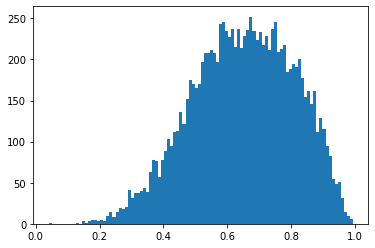

In [22]:
_ = plt.hist(aucs_htom, bins=100)

In [23]:
aucs_mtoh=[]
for i in range(h_ranks.shape[0]):
    labels = np.zeros(top_in_m.shape[0])
    labels[top_in_m[i]] = 1
    aucs_mtoh.append(roc_auc_score(y_true=labels, y_score=h_ranks[i]))

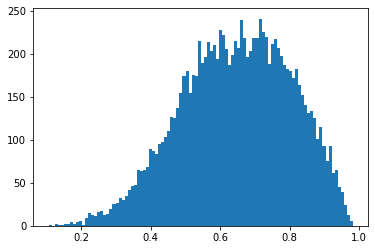

In [24]:
_ = plt.hist(aucs_mtoh, bins=100)

In [25]:
from numpy import random

In [26]:
shuff_iters = 5
shuff = [] * m_ranks.shape[0] * shuff_iters
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    for j in range(shuff_iters):
        labels[random.choice(m_ranks.shape[0], size=n_index, replace=False)] = 1
        shuff.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

In [27]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

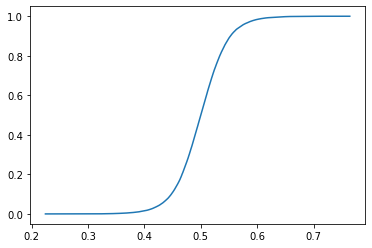

In [28]:
x, cdf =  ecdf(shuff)
plt.plot(x, cdf)

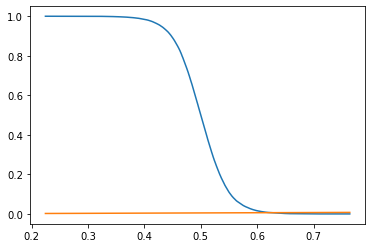

In [29]:
plt.plot(x, 1-cdf)
plt.plot(x, [.01]*x)

In [30]:
gene_aucs = pd.DataFrame(index=mouse_genes.index, columns=['mouse_auc', 'human_auc'], data=np.array([aucs_mtoh, aucs_htom]).T)

In [31]:
m_p_vals = np.interp(gene_aucs['mouse_auc'], x, 1-cdf)
h_p_vals = np.interp(gene_aucs['human_auc'], x, 1-cdf)

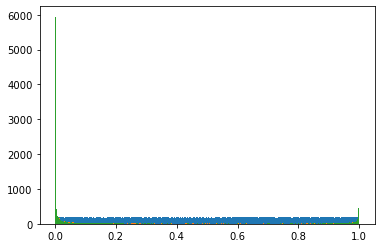

In [32]:
_, bins, _ = plt.hist(1-cdf, bins=300)
_, bins, _ = plt.hist(m_p_vals, bins=300)
_, bins, _ = plt.hist(h_p_vals, bins=300)

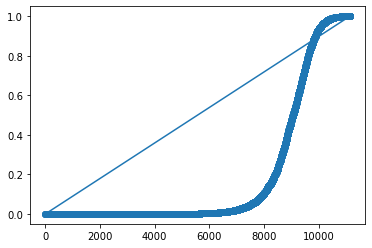

In [33]:
plt.scatter(np.arange(m_p_vals.shape[0]), np.sort(m_p_vals))
plt.plot(np.arange(m_p_vals.shape[0]), np.arange(m_p_vals.shape[0])/m_p_vals.shape[0])

In [41]:
jm = np.min(np.argwhere(np.arange(m_p_vals.shape[0])/m_p_vals.shape[0] - np.sort(m_p_vals)< 0)) 

In [42]:
jh = np.min(np.argwhere(np.arange(h_p_vals.shape[0])/h_p_vals.shape[0] - np.sort(h_p_vals)< 0)) 

In [43]:
jm,jh

(9813, 9843)

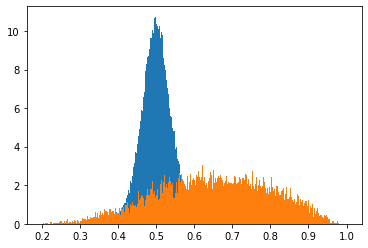

In [36]:
shuff_dense, bins, _ = plt.hist(shuff, bins=np.linspace(.2, 1, 300), density=True)
true_dense, bins, _ = plt.hist(gene_aucs.mean(axis=1), bins=bins, density=True)

In [37]:
def get_j_fdr(p_vals):
    return np.max(np.argwhere(np.arange(p_vals.shape[0])/p_vals.shape[0] - np.sort(p_vals) < 0)) 

In [38]:
jm = get_j_fdr(m_p_vals)

In [39]:
jm

11138

In [40]:
len(m_p_vals)

11139

In [ ]:
def fdr(p_vals):
    

In [37]:
alpha_adjust_m = .01 * jm / (m_p_vals.shape[0]*np.log(m_p_vals.shape[0]))
alpha_adjust_h = .01 * jh /(m_p_vals.shape[0]*np.log(m_p_vals.shape[0]))

In [38]:
alpha_adjust_h, alpha_adjust_m, 

(0.0009483068609139685, 0.000945320219372941)

In [39]:
gene_aucs['p_val_m'] = m_p_vals
gene_aucs['p_val_h'] = h_p_vals
gene_aucs['significant'] = (gene_aucs.p_val_m < alpha_adjust_m) & (gene_aucs.p_val_h < alpha_adjust_h)

In [40]:
gene_aucs

,mouse_auc,human_auc,p_val_m,p_val_h,significant
SLC39A1,0.798599,0.809853,0.000000,0.000000,True
SCAMP2,0.611336,0.599651,0.010346,0.016533,False
LYRM7,0.355551,0.430536,0.997469,0.949876,False
SYVN1,0.731228,0.375755,0.000020,0.993856,False
SHC4,0.549906,0.702532,0.110881,0.000079,False
...,...,...,...,...,...
DOCK9,0.551405,0.632966,0.104839,0.004382,False
PLXNB2,0.536651,0.646497,0.177698,0.002307,False
RGS8,0.580097,0.401243,0.035159,0.983437,False
CCNO,0.713142,0.783301,0.000033,0.000000,True


In [41]:
gene_aucs.significant.sum()

4314

In [42]:
gene_aucs.loc[gene_aucs.significant][['human_auc', 'mouse_auc']].min()

human_auc    0.663673
mouse_auc    0.663744
dtype: float64

In [43]:
gene_aucs.to_csv("../../data/prepared/aucs.tsv.gz", sep="\t")

In [44]:
spearmanr(gene_aucs.mouse_auc.values, gene_aucs.human_auc.values)

SpearmanrResult(correlation=0.8036577258042249, pvalue=0.0)